In [1]:
import torch,torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from model import Generator, iterate_minibatches, compute_loss, train


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
OCTAVE_NUM = 4
NOTE_NUM = 12
TIME_SCALE = 128


class LSTM_discriminator(nn.Module):
    def __init__(self,hidden_size = 1000,last_dim = 3):
        super(self.__class__, self).__init__()
        self.last_dim = last_dim
        self.hidden_size = hidden_size
        self.note_lstm = nn.LSTM(input_size = OCTAVE_NUM*last_dim,hidden_size = hidden_size)
        self.time_lstm = nn.LSTM(input_size = hidden_size,hidden_size = hidden_size)
        self.dense = nn.Linear(hidden_size,1)

    def forward(self,data):
        # data.size() =  (batch_size, TIME_SCALE, NOTE_NUM*OCTAVE_NUM, last_dim)
        # octave_data.size() =  (batch_size, TIME_SCALE, NOTE_NUM,OCTAVE_NUM*last_dim)
        batch_size,_,_,_ = data.size()
        octave_data = data.view(batch_size,TIME_SCALE,NOTE_NUM,OCTAVE_NUM,self.last_dim)\
                          .view(batch_size,TIME_SCALE,NOTE_NUM,OCTAVE_NUM*self.last_dim)
            
        # note_lstm_input.size() = (NOTE_NUM, batch_size*TIME_SCALE,OCTAVE_NUM*last_dim)
        note_lstm_input = octave_data.view(batch_size*TIME_SCALE,NOTE_NUM,OCTAVE_NUM*self.last_dim)\
                                     .transpose(0,1)
        # note_lstm_output.size() = (NOTE_NUM,batch_size*TIME_SCALE,hidden_size)
        note_lstm_output, _ = self.note_lstm(note_lstm_input)
        # time_lstm_input.size() = (TIME_SCALE,batch_size,hidden_size)
        time_lstm_input = note_lstm_output[-1].view(batch_size,TIME_SCALE,self.hidden_size)\
                                          .transpose(0,1)\
        # time_lstm_output.size() = (TIME_SCALE,batch_size,1000)
        time_lstm_output, _  = self.time_lstm(time_lstm_input)
        # dense_input.size() = (batch_size,1000)
        dense_input = time_lstm_output[-1]
        # dense_output.size() = (batch_size,1)
        dense_output = self.dense(dense_input)
        probs = F.sigmoid(dense_output)
        return probs
        
        
        

In [3]:
# device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
# # device = torch.device("cpu")
# discriminator = LSTM_discriminator(hidden_size=10).to(device)
# np_data = np.random.randn(10,TIME_SCALE,NOTE_NUM*OCTAVE_NUM,3)
# data = torch.FloatTensor(np_data).to(device)
# discriminator(data)

In [4]:
class LSTM_baseline(nn.Module):
    def __init__(self,hidden_size = 1000):
        super(self.__class__, self).__init__()
        self.hidden_size = hidden_size
        self.note_lstm = nn.LSTM(input_size = OCTAVE_NUM*3,hidden_size = hidden_size)
        self.time_lstm = nn.LSTM(input_size = hidden_size,hidden_size = hidden_size)
        self.dense = nn.Linear(hidden_size,1)

    def forward(self,data,_):
        # data.size() =  (batch_size, TIME_SCALE, NOTE_NUM*OCTAVE_NUM, 3)
        # octave_data.size() =  (batch_size, TIME_SCALE, NOTE_NUM,OCTAVE_NUM*3)
        batch_size,_,_,_ = data.size()
        octave_data = data.view(batch_size,TIME_SCALE,NOTE_NUM,OCTAVE_NUM,3)\
                          .view(batch_size,TIME_SCALE,NOTE_NUM,OCTAVE_NUM*3)
            
        # note_lstm_input.size() = (NOTE_NUM, batch_size*TIME_SCALE,OCTAVE_NUM*3)
        note_lstm_input = octave_data.view(batch_size*TIME_SCALE,NOTE_NUM,OCTAVE_NUM*3)\
                                     .transpose(0,1)
        # note_lstm_output.size() = (NOTE_NUM,batch_size*TIME_SCALE,hidden_size)
        note_lstm_output, _ = self.note_lstm(note_lstm_input)
        # time_lstm_input.size() = (TIME_SCALE,batch_size,hidden_size)
        time_lstm_input = note_lstm_output[-1].view(batch_size,TIME_SCALE,self.hidden_size)\
                                          .transpose(0,1)\
        # time_lstm_output.size() = (TIME_SCALE,batch_size,1000)
        time_lstm_output, _  = self.time_lstm(time_lstm_input)
        # dense_input.size() = (batch_size,1000)
        dense_input = time_lstm_output[-1]
        # dense_output.size() = (batch_size,1)
        dense_output = self.dense(dense_input)
        probs = F.sigmoid(dense_output)
        return probs

In [5]:
# discriminator = LSTM_baseline(hidden_size=1000).to(device)
# np_data = np.random.randn(10,TIME_SCALE,NOTE_NUM*OCTAVE_NUM,3)
# data = torch.FloatTensor(np_data).to(device)
# discriminator(data)

In [6]:
class BasicGenerator(nn.Module):
    def __init__(self,hidden_size = 1000):
        super(self.__class__, self).__init__()
        self.dense_in = nn.Linear(TIME_SCALE*NOTE_NUM*OCTAVE_NUM*3,hidden_size)
        self.dense_out = nn.Linear(hidden_size,TIME_SCALE*NOTE_NUM*OCTAVE_NUM*3)

    def forward(self,data,_):
        batch_size,_,_,_ = data.size()
        data = data.view(batch_size,-1)
        hid_data = self.dense_in(data)
        out_data = self.dense_out(hid_data)
        output = F.sigmoid(out_data.view(batch_size, TIME_SCALE, NOTE_NUM*OCTAVE_NUM, 3))
        return output
        

In [7]:
class BasicDiscriminator(nn.Module):
    def __init__(self,hidden_size = 1000, last_dim = 3):
        super(self.__class__, self).__init__()
        self.dense_in = nn.Linear(TIME_SCALE*NOTE_NUM*OCTAVE_NUM*last_dim,hidden_size)
        self.dense_out = nn.Linear(hidden_size,1)

    def forward(self,data):
        batch_size,_,_,_ = data.size()
        data = data.view(batch_size,-1)
        hid_data = self.dense_in(data)
        out_data = self.dense_out(hid_data)
        output = F.sigmoid(out_data)
        return output

In [8]:
criterion_bce_play = nn.BCELoss()  
criterion_bce_replay = nn.BCELoss() 
criterion_mse = nn.MSELoss()  

def compute_loss(y_pred, y_true):
    
    played = y_true[:, :, :, 0]
    
    bce_note = criterion_bce_play(y_pred[:, :, :, 0], y_true[:, :, :, 0])

    replay = played*y_pred[:, :, :, 1] + (1 - played)*y_true[:, :, :, 1]
    
    bce_replay = criterion_bce_replay(replay, y_true[:, :, :, 1])
    
    #volume = played*y_pred[:, :, :, 2] + (1 - played)*y_true[:, :, :, 2]
    #mse = criterion_mse(volume, y_true[:, :, :, 2] )
    
    return bce_note + bce_replay# + mse

def g_loss(p_fake,sound,in_probs,baseline_pred,y_true,eps = 1e-8):

    gen_confidence = sound[:,:,:,:2]*in_probs[:,:,:,:2]\
            +(1-sound[:,:,:,:2])*(1-in_probs[:,:,:,:2])

    print('p_fake: ',p_fake.mean().cpu().data.numpy(),'probs: ',gen_confidence.mean().cpu().data.numpy())
    return -((gen_confidence+eps).log().sum(dim =-1).sum(dim =-1).sum(dim =-1)*(p_fake-baseline_pred)).mean()
def d_loss(p_fake, p_true,eps = 1e-8):

    return -(1-p_fake+eps).log().mean()-(p_true+eps).log().mean()
    
def bl_loss(bl_pred,real_reward):
    return (bl_pred-real_reward).pow(2).mean()



In [29]:
import torch.utils.data

def sample_sound(data_gen):
    size = data_gen.size()
    rand = torch.rand(*size).cuda()
    sample = (rand<data_gen).type(torch.FloatTensor).cuda()
    sample[:,:,:,2] = 1
    return sample
 
import torch.utils.data

    

def train_GAN(generator,discriminator,baseline,X_loader,num_epochs = 3,g_lr = 0.001, d_lr = 0.001,bl_lr = 0.001):
    generator.train()
    discriminator.train()
    generator.train()
    g_optimizer = torch.optim.Adam(generator.parameters(),     lr=g_lr,weight_decay = 0)#, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=d_lr,weight_decay = 0)#, betas=(0.5, 0.999))
    bl_optimizer = torch.optim.Adam(baseline.parameters(), lr=bl_lr)
    
    d_losses = []
    g_losses = []
    bl_losses = []
    for epoch in range(num_epochs):
        for i, [x_batch,ch_batch] in enumerate(X_loader):
            x_batch = x_batch.cuda()
            ch_batch = ch_batch.cuda()
            x_batch[:,:,:,2] = 1
            ch_batch[:,:,:,2] = 1
            
            # Optimize D

            data_gen = generator(x_batch,ch_batch)
            sound = sample_sound(data_gen).data
#             sound[:,:,:,1] = sound[:,:,:,1]*sound[:,:,:,0]
            #concat_sound = torch.cat([x_batch[:,1:TIME_SCALE//2+1,:,:],sound[:,TIME_SCALE//2:,:,:]],dim = 1)
            false_example = torch.cat([sound,x_batch],dim = -1)
            true_example = torch.cat([ch_batch,x_batch],dim = -1)
            loss = d_loss(discriminator(false_example), discriminator(true_example))
            d_optimizer.zero_grad()
            loss.backward()
#             print(loss.grad)
            d_optimizer.step()
            d_losses.append(loss.data.cpu().numpy())
        
            # Optimize BL
            data_gen = generator(x_batch,ch_batch)
            sound = sample_sound(data_gen).data
#             sound[:,:,:,1] = sound[:,:,:,1]*sound[:,:,:,0]
            false_example = torch.cat([sound,x_batch],dim = -1)
            loss = bl_loss(baseline(x_batch,ch_batch),discriminator(false_example))
            bl_optimizer.zero_grad()
            loss.backward()
            bl_optimizer.step()
            bl_losses.append(loss.data.cpu().numpy())
            
#             # Optimize G
            if i%2==0:
                data_gen = generator(x_batch,ch_batch)
                sound = sample_sound(data_gen).data
    #             sound[:,:,:,1] = sound[:,:,:,1]*sound[:,:,:,0]
                #concat_sound = torch.cat([x_batch[:,1:TIME_SCALE//2+1,:,:],sound[:,TIME_SCALE//2:,:,:]],dim = 1)

                false_example = torch.cat([sound,x_batch],dim = -1)
                true_example = torch.cat([ch_batch,x_batch],dim = -1)
                handle = np.random.randint(0,2)
                if handle == 0:
                    loss = g_loss(discriminator(false_example),sound,data_gen,baseline(x_batch,ch_batch),ch_batch)#,sound.data,data_gen)
                else:
                    loss = g_loss(discriminator(true_example).cuda(),ch_batch,data_gen,baseline(x_batch,ch_batch),ch_batch)#,sound.data,data_gen)
                g_optimizer.zero_grad()
                loss += compute_loss(data_gen,ch_batch)
                loss.backward()
    #             print(loss.grad)
                g_optimizer.step()
                g_losses.append(loss.data.cpu().numpy())
    return generator,discriminator,baseline,np.array(g_losses),np.array(d_losses),np.array(bl_losses)

In [226]:
from dataset import load_all
from constants import *

styles= [['data/Bach1']]
train_data, train_labels = load_all(styles, BATCH_SIZE, TIME_SCALE)
X_tr = train_data[0]
y_tr = train_labels[0]
# X_te = train_data[0][N:2*N]
train_data[0].shape,y_tr.shape
#y_te = train_labels[0][-1:]

((81, 128, 48, 3), (81, 128, 48, 3))

In [11]:
X_loader = torch.utils.data.DataLoader(\
            torch.utils.data.TensorDataset(\
            *(torch.FloatTensor(X_tr),
            torch.FloatTensor(y_tr))),\
            batch_size=16,shuffle=True)


In [121]:
import gc
with torch.cuda.device(GPU):
    torch.cuda.empty_cache()
    gc.collect() 

In [30]:
GPU = 2
with torch.cuda.device(GPU):
    # device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")
    generator = Generator().cuda()
    # generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_canonical')))
    generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_canonical')))
    discriminator = LSTM_discriminator(hidden_size=300,last_dim=6).cuda()
#     # generator = BasicGenerator().cuda()
    baseline = LSTM_baseline(hidden_size=300).cuda()
    #discriminator = BasicDiscriminator(last_dim=6).cuda()
    generator,discriminator,baseline,g_losses,d_losses,bl_losses =\
                    train_GAN(generator,discriminator,baseline,\
                            X_loader,num_epochs = 100, g_lr = 1*1e-3,d_lr=1*1e-2, bl_lr = 1*1e-4)

p_fake:  0.50329024 probs:  0.9402609
p_fake:  1.0 probs:  0.94563
p_fake:  1.0 probs:  0.93579894
p_fake:  0.5872172 probs:  0.9011283
p_fake:  0.43306604 probs:  0.86784786
p_fake:  0.50421786 probs:  0.8442467
p_fake:  0.5247569 probs:  0.8284126
p_fake:  1.0 probs:  0.84970784
p_fake:  0.5001404 probs:  0.8858357
p_fake:  1.0 probs:  0.92977977
p_fake:  0.5002968 probs:  0.944524
p_fake:  0.49942654 probs:  0.95672494
p_fake:  0.4995026 probs:  0.96533155
p_fake:  0.50042063 probs:  0.970443
p_fake:  1.0 probs:  0.9556015
p_fake:  0.49951348 probs:  0.97500944
p_fake:  0.4998057 probs:  0.9757797
p_fake:  0.50050384 probs:  0.97622985
p_fake:  1.0 probs:  0.9593873
p_fake:  0.49968463 probs:  0.9748698
p_fake:  1.0 probs:  0.9581735
p_fake:  1.0 probs:  0.9527878
p_fake:  0.49976793 probs:  0.9633131
p_fake:  1.0 probs:  0.95010716
p_fake:  0.4999589 probs:  0.952662
p_fake:  1.0 probs:  0.945901
p_fake:  0.50020725 probs:  0.9412864
p_fake:  0.4999445 probs:  0.93535566
p_fake:  0

p_fake:  1.0 probs:  0.95631117
p_fake:  0.50008816 probs:  0.95563126
p_fake:  0.4999362 probs:  0.9481778
p_fake:  0.49974918 probs:  0.93873304
p_fake:  0.49989516 probs:  0.9352295
p_fake:  1.0 probs:  0.9397111
p_fake:  1.0 probs:  0.9458429
p_fake:  1.0 probs:  0.9542532
p_fake:  0.50044453 probs:  0.9647329
p_fake:  1.0 probs:  0.9651577
p_fake:  1.0 probs:  0.9595656
p_fake:  1.0 probs:  0.95792323
p_fake:  1.0 probs:  0.95155543
p_fake:  0.49960157 probs:  0.94240063
p_fake:  1.0 probs:  0.95149523
p_fake:  0.49999687 probs:  0.94050074
p_fake:  1.0 probs:  0.94830686
p_fake:  0.5001538 probs:  0.952949
p_fake:  0.50046515 probs:  0.9554233
p_fake:  0.5002716 probs:  0.9597979
p_fake:  0.5001514 probs:  0.9648451
p_fake:  1.0 probs:  0.9625602
p_fake:  0.4997891 probs:  0.9667348
p_fake:  1.0 probs:  0.96316975
p_fake:  1.0 probs:  0.9636057
p_fake:  1.0 probs:  0.96261954
p_fake:  0.4998052 probs:  0.9555359
p_fake:  0.49995708 probs:  0.95475817
p_fake:  0.50033456 probs:  0

p_fake:  0.5013625 probs:  0.95535636
p_fake:  0.50606817 probs:  0.948149
p_fake:  1.0 probs:  0.95262694
p_fake:  1.0 probs:  0.95311284
p_fake:  1.0 probs:  0.954732
p_fake:  1.0 probs:  0.95993423
p_fake:  1.0 probs:  0.9632519
p_fake:  0.5038761 probs:  0.9659712
p_fake:  1.0 probs:  0.96666527
p_fake:  0.49934816 probs:  0.96927094
p_fake:  0.49721026 probs:  0.9703856
p_fake:  1.0 probs:  0.96287805
p_fake:  0.49789098 probs:  0.9662652
p_fake:  0.49913225 probs:  0.96920854
p_fake:  0.501631 probs:  0.9667136
p_fake:  1.0 probs:  0.96199924
p_fake:  1.0 probs:  0.9624586
p_fake:  0.4990562 probs:  0.95725375
p_fake:  0.4984588 probs:  0.9590509
p_fake:  1.0 probs:  0.9641934
p_fake:  0.5020389 probs:  0.95915604
p_fake:  0.5043524 probs:  0.95662117
p_fake:  1.0 probs:  0.9560497
p_fake:  1.0 probs:  0.9594713
p_fake:  1.0 probs:  0.9612048
p_fake:  0.4964246 probs:  0.96033216
p_fake:  1.0 probs:  0.9609193
p_fake:  1.0 probs:  0.9663052
p_fake:  1.0 probs:  0.95863086
p_fake:

p_fake:  1.0 probs:  0.958327
p_fake:  1.0 probs:  0.9614571
p_fake:  1.0 probs:  0.95864445
p_fake:  0.47031027 probs:  0.95665336
p_fake:  1.0 probs:  0.9644969
p_fake:  0.4794934 probs:  0.96352226
p_fake:  1.0 probs:  0.9634586
p_fake:  1.0 probs:  0.95952296
p_fake:  0.5368211 probs:  0.9570187
p_fake:  0.5146213 probs:  0.9661047
p_fake:  1.0 probs:  0.95916885
p_fake:  1.0 probs:  0.9633171
p_fake:  0.5363889 probs:  0.9603002
p_fake:  0.4474278 probs:  0.95664066
p_fake:  1.0 probs:  0.9633004
p_fake:  1.0 probs:  0.9628683
p_fake:  0.5344343 probs:  0.9663837
p_fake:  1.0 probs:  0.9560194
p_fake:  1.0 probs:  0.9659961
p_fake:  0.33211362 probs:  0.96337867
p_fake:  1.0 probs:  0.9630482
p_fake:  1.0 probs:  0.96197087
p_fake:  1.0 probs:  0.96394557
p_fake:  1.0 probs:  0.964464
p_fake:  1.0 probs:  0.96167785
p_fake:  0.47272095 probs:  0.9571852
p_fake:  1.0 probs:  0.96461076
p_fake:  1.0 probs:  0.95868975
p_fake:  0.4784901 probs:  0.96379906
p_fake:  0.51554966 probs: 

p_fake:  1.0 probs:  0.9674194
p_fake:  0.20870277 probs:  0.96108294
p_fake:  0.21700472 probs:  0.9596698
p_fake:  0.124774516 probs:  0.95564705
p_fake:  0.16451548 probs:  0.95132023
p_fake:  0.22780545 probs:  0.9495106
p_fake:  1.0 probs:  0.9545961
p_fake:  1.0 probs:  0.9630353
p_fake:  0.40742064 probs:  0.959686
p_fake:  0.6027678 probs:  0.96778744
p_fake:  1.0 probs:  0.96700245
p_fake:  1.0 probs:  0.96886975
p_fake:  0.1159464 probs:  0.9698475
p_fake:  0.2587717 probs:  0.96550703
p_fake:  0.58957154 probs:  0.96744055
p_fake:  1.0 probs:  0.9589786
p_fake:  1.0 probs:  0.9576362
p_fake:  1.0 probs:  0.96061724
p_fake:  1.0 probs:  0.9644912
p_fake:  0.3861859 probs:  0.95882577
p_fake:  0.28675038 probs:  0.96037906
p_fake:  1.0 probs:  0.9623673
p_fake:  1.0 probs:  0.9621697
p_fake:  1.0 probs:  0.96067715
p_fake:  1.0 probs:  0.96269196
p_fake:  0.12342189 probs:  0.955981
p_fake:  0.13615237 probs:  0.95712703
p_fake:  0.18494067 probs:  0.9563894
p_fake:  0.1607891

p_fake:  0.08201542 probs:  0.9557516
p_fake:  1.0 probs:  0.95987135
p_fake:  1.0 probs:  0.95871687
p_fake:  1.0 probs:  0.960227
p_fake:  1.0 probs:  0.96020955
p_fake:  0.20204486 probs:  0.96791106
p_fake:  1.0 probs:  0.95943874
p_fake:  0.07783362 probs:  0.962243
p_fake:  0.07887547 probs:  0.96091276
p_fake:  1.0 probs:  0.95983905
p_fake:  0.20061512 probs:  0.9645068
p_fake:  1.0 probs:  0.966943
p_fake:  0.14012812 probs:  0.96251374
p_fake:  0.11844156 probs:  0.95687675
p_fake:  1.0 probs:  0.9655109
p_fake:  1.0 probs:  0.95989084
p_fake:  1.0 probs:  0.9590568
p_fake:  0.1812376 probs:  0.95981556
p_fake:  1.0 probs:  0.9524057
p_fake:  1.0 probs:  0.9593325
p_fake:  1.0 probs:  0.95939183
p_fake:  1.0 probs:  0.9619481
p_fake:  1.0 probs:  0.9614272
p_fake:  0.092997745 probs:  0.9616344
p_fake:  1.0 probs:  0.96174246
p_fake:  1.0 probs:  0.968659
p_fake:  0.109792136 probs:  0.9625507
p_fake:  0.053113714 probs:  0.9570138
p_fake:  1.0 probs:  0.95867366
p_fake:  0.1

KeyboardInterrupt: 

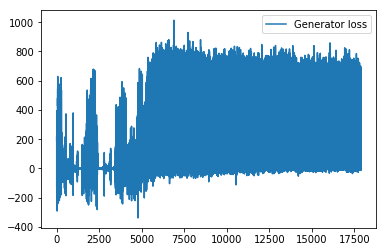

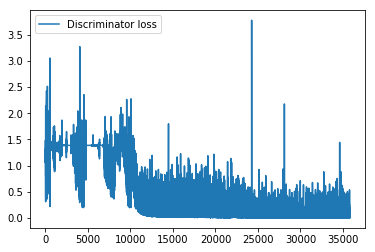

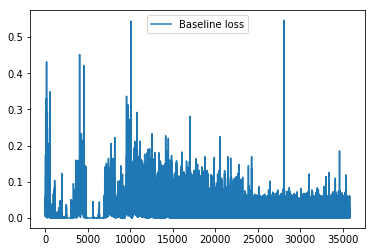

In [22]:
import matplotlib.pyplot as plt
plt.plot(g_losses,label = "Generator loss")
plt.legend()
plt.show()
plt.plot(d_losses,label = "Discriminator loss")
plt.legend()
plt.show()
plt.plot(bl_losses,label = "Baseline loss")
plt.legend()
plt.show()

In [31]:
from generate import write_file, generate
# import gc
# torch.cuda.empty_cache()
# gc.collect() 
with torch.cuda.device(GPU):
    write_file('output/canonical_test', generate(generator, 4))

  2%|▏         | 1/64 [00:00<00:06,  9.13it/s]

Generating with no styles:


100%|██████████| 64/64 [00:07<00:00,  9.09it/s]

Writing file out/samples/output/canonical_test_0.mid


In [321]:
def train_GAN(generator,discriminator,baseline,X_loader,num_epochs = 3,g_lr = 0.001, d_lr = 0.001,bl_lr = 0.001):
    generator.train()
    discriminator.train()
    generator.train()
    g_optimizer = torch.optim.Adam(generator.parameters(),     lr=g_lr,weight_decay = 0)#, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=d_lr,weight_decay = 0)#, betas=(0.5, 0.999))
    bl_optimizer = torch.optim.Adam(baseline.parameters(), lr=bl_lr)
    
    d_losses = []
    g_losses = []
    bl_losses = []
    for epoch in range(num_epochs):
        for i, [x_batch,ch_batch] in enumerate(X_loader):
            x_batch = x_batch.cuda()
            ch_batch = ch_batch.cuda()
            x_batch[:,:,:,2] = 1
            ch_batch[:,:,:,2] = 1
            
            # Optimize D
            data_gen = generator(x_batch,ch_batch)
            sound = sample_sound(data_gen).data
            false_example = sound
            true_example = ch_batch
            loss = d_loss(discriminator(false_example), discriminator(true_example))
            d_optimizer.zero_grad()
            loss.backward()
            d_optimizer.step()
            d_losses.append(loss.data.cpu().numpy())
        
            # Optimize BL
            data_gen = generator(x_batch,ch_batch)
            sound = sample_sound(data_gen).data
            false_example = sound
            loss = bl_loss(baseline(x_batch,ch_batch),discriminator(false_example))
            bl_optimizer.zero_grad()
            loss.backward()
            bl_optimizer.step()
            bl_losses.append(loss.data.cpu().numpy())
            
            # Optimize G
            data_gen = generator(x_batch,ch_batch)
            sound = sample_sound(data_gen).data

            false_example = sound
            true_example = ch_batch
            g_optimizer.zero_grad()
            loss += compute_loss(data_gen,ch_batch)
            loss.backward()
            g_optimizer.step()
            g_losses.append(loss.data.cpu().numpy())
            
            if i%2==0:
                data_gen = generator(x_batch,ch_batch)
                sound = sample_sound(data_gen).data

                false_example = sound
                true_example = ch_batch
                handle = np.random.randint(0,2)
                if handle == 0:
                    loss = g_loss(discriminator(false_example),sound,data_gen,baseline(x_batch,None),None)#,sound.data,data_gen)
                else:
                    loss = g_loss(discriminator(true_example),ch_batch,data_gen,baseline(x_batch,None),None)#,sound.data,data_gen)
                g_optimizer.zero_grad()
                loss += compute_loss(data_gen,ch_batch)
                loss.backward()
    #             print(loss.grad)
                g_optimizer.step()
                g_losses.append(loss.data.cpu().numpy())
    return generator,discriminator,baseline,np.array(g_losses),np.array(d_losses),np.array(bl_losses)

In [222]:
def EB(sound):
    play = sound[:,:,:,0]
    num_notes = play.sum(dim=-1)
    is_empty = (num_notes==0).float()
    return is_empty.mean()*100
    
def UPC(sound):
    play = sound[:,:,:,0]
    batch_size,time_scale,note_num = play.size()
    octave_play = play.view(batch_size,time_scale,12,note_num//12)
    pitch_play = octave_play.sum(dim = -1)>0
    num_pitches = pitch_play.sum(dim=-1)
    return num_pitches.float().mean()

def num_notes(play,replay):
    play = play*(1-replay)
    batch_size,time_scale,note_num = play.size()
    shifted_play = torch.zeros(batch_size,time_scale,note_num).cuda()
    shifted_play[:,:-1,:] = play[:,1:,:]
    cond_change = shifted_play-play
    return (cond_change>0).float().sum()

def QN(sound, qualified_len = 3):
    batch_size,time_scale,note_num,_ = sound.size()
    play = sound[:,:,:,0]
    replay = sound[:,:,:,1]
    shifted_play = torch.zeros(batch_size,time_scale,note_num).cuda()
    
    shifted_play[:,:time_scale-qualified_len,:] = play[:,qualified_len:,:]
    qualified_play = play*shifted_play
    
    general_num_notes = num_notes(play,replay)
    num_qualified_notes = num_notes(qualified_play,replay)
    return num_qualified_notes/general_num_notes*100
    

In [228]:
sound = torch.FloatTensor(X_tr).cuda()
EB(sound),UPC(sound),QN(sound)



(tensor(7.4074, device='cuda:0'),
 tensor(3.3108, device='cuda:0'),
 tensor(85.6642, device='cuda:0'))